<a href="https://colab.research.google.com/github/naoya1110/nitkc-ncku-ai-robotics/blob/main/Week03_Convolutional_Neural_Network_with_CIFAR10_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this week we are going to learn about

*   Convolutional Neural Network (CNN)
*   Conv2D Layer
*   MaxPooling 2D Layer

Last week we have implemented a simple neural network model for classiying irises from its 4 feature values. The model we used was made with several linear layers only.Such models can be applied for image classification tasks as well, but not very efficient. On the other hand, CNNs are more appropriate for image tasks. By invention of CNNs, the accuracy of image classification AI has been improved drastically, and now beyond human levels. Most of modern image recognition AIs use CNNs.

We are going to build a simple CNN and train it with CIFAR10 dataset. CIFAR10 dataset consists of 10 categories of 32x32 pixels' color images as shown bellow. 

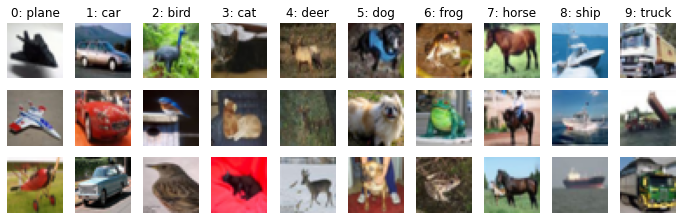

**GPU**

We will need a GPU to train CNN models, so please make sure your runtime type is GPU.

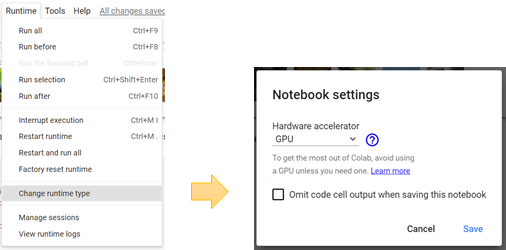

We can check if GPU (cuda) is available.

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


**General Packages**

Then let's import some general Python packages.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Data Preparation

**CIFAR10**

CIFAR10 dataset can be loaded from `torchvision.datasets`. The `torchvision` package consists of popular datasets, model architectures, and common image transformations for computer vision.

*   CIFAR10 https://www.cs.toronto.edu/~kriz/cifar.html
* torchvison https://pytorch.org/vision/stable/index.html

In [3]:
from torchvision.datasets import CIFAR10

xy_train = CIFAR10(root="cifar10", train=True, download=True)
xy_test = CIFAR10(root="cifar10", train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10/cifar-10-python.tar.gz to cifar10
Files already downloaded and verified


CIFAR10 datasets consists of 50,000 and 10,000 labeled images for training and testing respectively.

In [4]:
print("train data", len(xy_train))
print("test data", len(xy_test))

train data 50000
test data 10000


We can take individual set of image and label by indexing the dataset. The image data is in PIL format and this can be visualized with matplotlib.

* Pillow (PIL Fork) https://pillow.readthedocs.io/en/latest/handbook/index.html

<PIL.Image.Image image mode=RGB size=32x32 at 0x7FDB500C1C90>
6


Text(0.5, 1.0, '6')

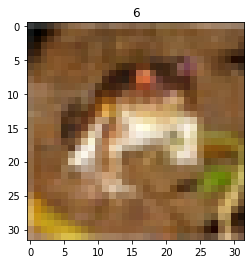

In [5]:
image, label = xy_train[0]
print(image)
print(label)

plt.imshow(image)
plt.title(label)

The label number corresponds to 10 categories as shown below.

In [6]:
classnames = {0:"plane", 
                      1:"car", 
                      2:"bird", 
                      3:"cat", 
                      4:"deer",
                      5:"dog", 
                      6:"frog", 
                      7:"horse",
                      8:"ship",
                      9:"truck"}

classnames

{0: 'plane',
 1: 'car',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In order to handle data with PyTorch, the data format needs to be in `torch.tensor`. We can get `torch.tensor` data by specifying the parameter of `transform=transforms.ToTensor()` when loading from `torchvision.datasets`.

In [7]:
from torchvision import transforms

xy_train = CIFAR10(root="cifar10", train=True, download=False, transform=transforms.ToTensor())
xy_test = CIFAR10(root="cifar10", train=False, download=False, transform=transforms.ToTensor())

Now the image data is in `torch.tensor`.

In [8]:
image, label = xy_train[0]
print(type(image))

<class 'torch.Tensor'>


Note that one of the differences between `PIL` and `torch.tensor` image data is its order of data shape as shown below.

|  data format  |  shape  |
| :----: | :----: |
|  PIL  |  (32, 32, 3)  <br> (height, width, channel)|
|  torch.tensor  |  (3, 32, 32)  <br> (channel, height, width)|


The image data with the shape of (3, 32, 32) cannot be visualized using matplotlib.


TypeError: ignored

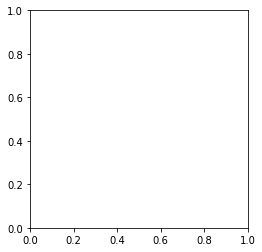

In [9]:
plt.imshow(image)

**Data Loader**

Anyway we create `DataLoader` objects for feeding data to a PyTorch model. This is exactly same as we did with Iris dataset.

In [10]:
from torch.utils.data import DataLoader

train_loader = DataLoader(xy_train, batch_size=32, shuffle=True)
test_loader = DataLoader(xy_test, batch_size=32, shuffle=False)

That's it for data preparation!

# Model Building

**Model Architecture**

Next step is to build a convolutional neural network (CNN). We will build a model shown below. The model consists of 2 parts. One is called features part, and other is called classifier part. The features part consists of Conv2d (2D convolution) layers with ReLU actiovation function and MaxPool2D layers. The classifier part consists of Linear layers with ReLU activation and a dropout layer. The features part extracts features of input image and the flatten layer converts it to 1D feature data. Then the classifier part classifies the image class from feature data.

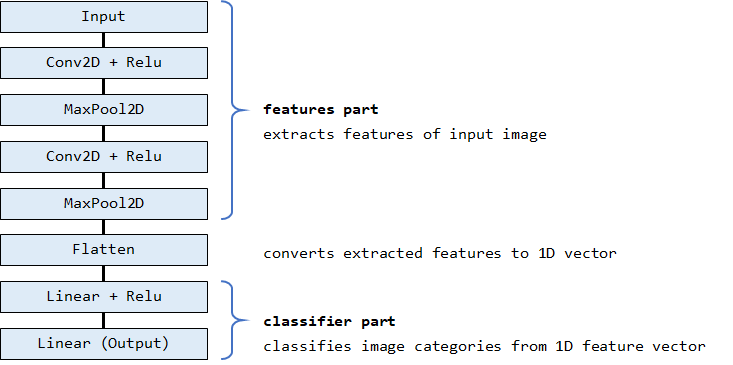

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128*8*8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)  
        return x
    
model = Model()
print(model)

Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


Then we load the model on GPU.

In [23]:
model = model.to(device)

In order to visualize the model architecture, `torchsummary` pakage is very useful.

In [24]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

torch.Size([32, 3, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Sequential: 1-1                        [32, 128, 8, 8]           --
│    └─Conv2d: 2-1                       [32, 64, 32, 32]          1,792
│    └─ReLU: 2-2                         [32, 64, 32, 32]          --
│    └─MaxPool2d: 2-3                    [32, 64, 16, 16]          --
│    └─Conv2d: 2-4                       [32, 128, 16, 16]         73,856
│    └─ReLU: 2-5                         [32, 128, 16, 16]         --
│    └─MaxPool2d: 2-6                    [32, 128, 8, 8]           --
├─Sequential: 1-2                        [32, 10]                  --
│    └─Linear: 2-7                       [32, 256]                 2,097,408
│    └─ReLU: 2-8                         [32, 256]                 --
│    └─Linear: 2-9                       [32, 10]                  2,570
Total params: 2,175,626
Trainable params: 2,175,626
Non-trainable pa

**Conv2D**

Conv2D layer creates output images by calculating dot products of the input image and the filters (also called as kernels). The size of filters are usually smaller than the input image, therefore the filters are moved across the whole input image. Usually several different filters are used in a Conv2D layer resulting in several different output images. Numbers in the filters are the trainable parameters, therefore these values are updated during training.

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

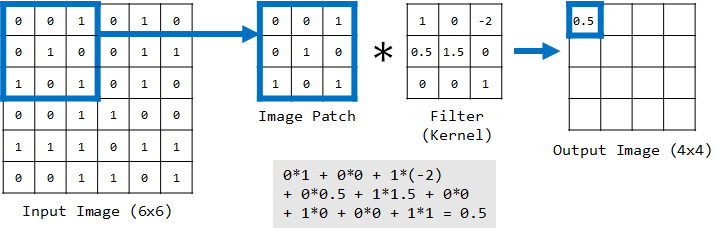

You can play with the code below to see how the Conv2D layer works.

torch.Size([8, 8])


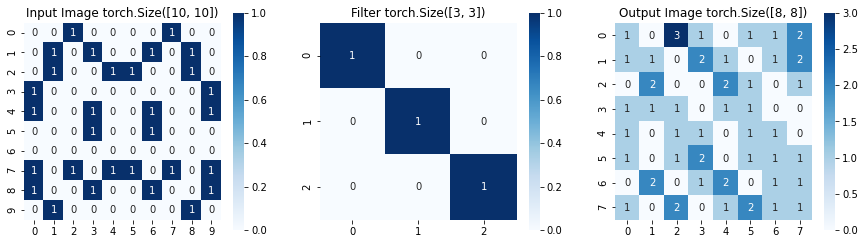

In [31]:
# input image --- do not change
input_img = torch.tensor([0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,1,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0], dtype=torch.float32)
input_img = input_img.view(10,10)
h, w = input_img.shape


# enable/disable padding
padding = False
if padding:
    pad_img = torch.zeros((h+2, w+2), dtype=torch.float32)
    pad_img[1:1+h, 1:1+w] = input_img
    input_img = pad_img
    h, w = input_img.shape

# define a filter
filter = torch.tensor([[1, 0, 0],
                               [0, 1, 0],
                               [0, 0, 1]], dtype=torch.float32)

# create an empty output image
output_img = torch.zeros((h-2, h-2), dtype=torch.float32)
print(output_img.shape)

# do convolution
for i in range(h-2):
    for j in range(w-2):
        patch_img = input_img[i:i+3, j:j+3]
        conv = torch.sum(patch_img*filter)
        output_img[i,j]=conv

# Visualize input image, filter and output image
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.heatmap(input_img, annot=True, square=True, cmap="Blues")
plt.title(f"Input Image {input_img.shape}")

plt.subplot(1,3,2)
sns.heatmap(filter, annot=True, square=True, cmap="Blues")
plt.title(f"Filter {filter.shape}")

plt.subplot(1,3,3)
sns.heatmap(output_img, annot=True, square=True, cmap="Blues")
plt.title(f"Output Image {output_img.shape}")

conv_img = output_img

**MaxPool2D**

MaxPool2D layer creates down-sampled output images by taking the maximum number in a partial area of input images.

https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

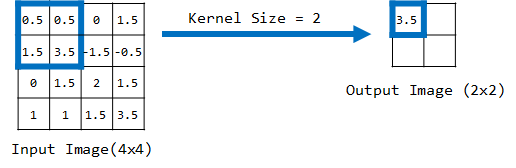

Text(0.5, 1.0, 'Output Image torch.Size([4, 4])')

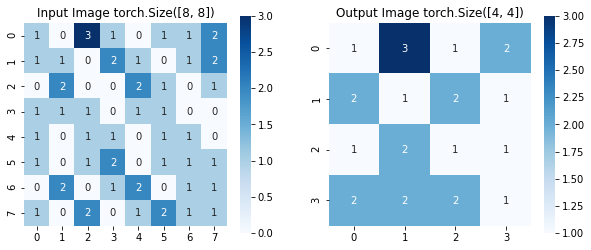

In [32]:
input_img = conv_img

h, w = input_img.shape

output_img = torch.zeros((int(h/2), int(w/2)), dtype=torch.float32)

# max pooling
for i in range(int(h/2)):
    for j in range(int(w/2)):
        patch_img = input_img[2*i:2*i+2, 2*j:2*j+2]
        max = torch.max(patch_img)
        output_img[i,j] = max

# visualize input and output data
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.heatmap(input_img, annot=True, square=True, cmap="Blues")
plt.title(f"Input Image {input_img.shape}")

plt.subplot(1,2,2)
sns.heatmap(output_img, annot=True, square=True, cmap="Blues")
plt.title(f"Output Image {output_img.shape}")

# Training

**Loss Function**

We use the cross-entropy loss as the loss function since this is a classification task.

In [33]:
loss_func = nn.CrossEntropyLoss()

**Optimizer**

We use the Adam optimizer.

In [34]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-3)

**Training Loop**

Now we train the model with CIFAR10 datasets. The training loop is almost same as we did before exept for loading data on GPU.







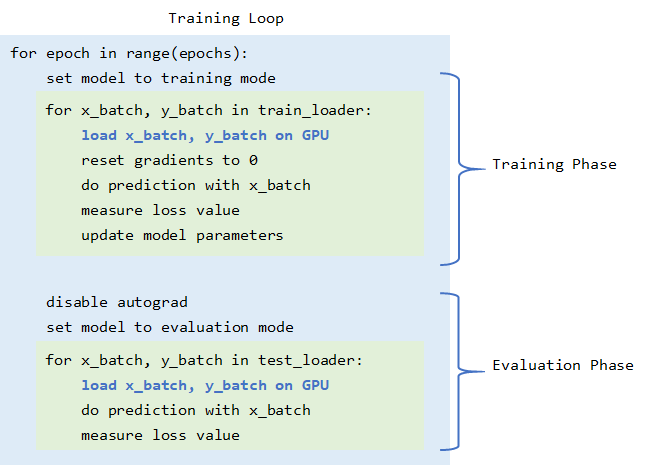

In [35]:
epochs = 10

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(epochs):

    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics value
    train_accuracy = 0
    train_loss = 0
    test_accuracy = 0
    test_loss = 0

    model.train()          # set model to training mode

    for x_batch, y_batch in tqdm(train_loader):      # take mini batch data from train_loader
        
        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU
        
        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)                # do prediction
        loss = loss_func(p_batch, y_batch)        # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                           # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)          # 
        train_accuracy += (p_batch_label == y_batch).sum()   # count up number of correct predictions

    with torch.no_grad():     # disable autograd for saving memory usage
        model.eval()          # set model to evaluation mode

        for x_batch, y_batch in tqdm(test_loader):   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)            # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            test_loss += loss.item()                          # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)        # convert p_batch vector to target class index
            test_accuracy += (p_batch_label == y_batch).sum()  # count up number of correct predictions

    train_accuracy = train_accuracy/len(xy_train)   # determine accuracy for training data
    test_accuracy = test_accuracy/len(xy_test)      # determin accuracy for test data
    train_loss = train_loss/len(train_loader)           # determin loss for training data
    test_loss = test_loss/len(test_loader)              # determin loss for test data 

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Test: Accuracy={test_accuracy:.3f} Loss={test_loss:.3f}\n")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

Epoch 1/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.499 Loss=1.383, Test: Accuracy=0.592 Loss=1.136

Epoch 2/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.649 Loss=0.988, Test: Accuracy=0.677 Loss=0.935

Epoch 3/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.711 Loss=0.820, Test: Accuracy=0.703 Loss=0.858

Epoch 4/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.752 Loss=0.706, Test: Accuracy=0.697 Loss=0.889

Epoch 5/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.786 Loss=0.606, Test: Accuracy=0.699 Loss=0.888

Epoch 6/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.819 Loss=0.512, Test: Accuracy=0.714 Loss=0.887

Epoch 7/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.851 Loss=0.423, Test: Accuracy=0.720 Loss=0.934

Epoch 8/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.876 Loss=0.349, Test: Accuracy=0.715 Loss=1.021

Epoch 9/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.899 Loss=0.285, Test: Accuracy=0.706 Loss=1.149

Epoch 10/10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train: Accuracy=0.921 Loss=0.228, Test: Accuracy=0.701 Loss=1.269



**Learning Curves**

Let's visualize the accuracy curves for train and test data.

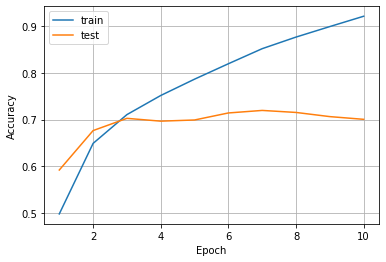

In [36]:
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, test_accuracy_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

Also the loss curves for train and test data.

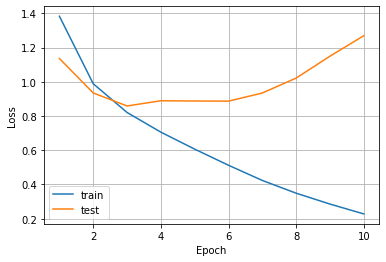

In [37]:
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, test_loss_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

**Overfitting**

You might have noticed that the test accuracy saturates after first several epochs while the train accuracy keeps increasing. Also the test loss stops decreasing and starts to increase  while the train loss keeps decreasing. This means the model is fitted too much for training data, i.e. the model can predict very well for only the training data, but not for any other data like test data. This behavior is called overfitting. Generally deep neural network models have huge number of parameters and the model can just remember the training data instead of understanding general rules in the training data. But our goal is to realize a model that can predict correctly for unseen data. So when we train the model, we have to try to increase the test accuracy avoiding overfitting.

# Evaluation

**Predictions for Test Data**

Anyway let's see predictions for some test data.

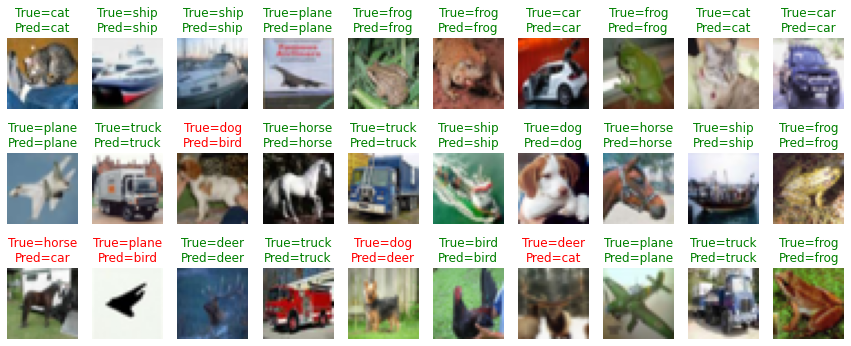

In [39]:
with torch.no_grad():
    model.eval()

    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        p_batch = model(x_batch)
        p_batch_label = torch.argmax(p_batch, dim=1)

        plt.figure(figsize=(15, 6))
        for i in range(30):
            image = x_batch[i].to("cpu").numpy()
            image = np.transpose(image, (1,2,0))
            plt.subplot(3, 10, i+1)
            plt.imshow(image)

            true_class = classnames[y_batch[i].item()]
            pred_class = classnames[p_batch_label[i].item()]
            if true_class == pred_class:
                color = "green"
            else:
                color = "red"
            plt.title(f"True={true_class}\nPred={pred_class}", color=color)
            plt.axis("off")
        
        break

**Test Accuracy**

We should check accuracy of the model for all of the test data.

In [40]:
correct_count = 0
y_true_all = np.array([])
p_batch_label_all = np.array([])

with torch.no_grad():
    model.eval()
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        p_batch = model(x_batch)
        p_batch_label = torch.argmax(p_batch, dim=1)

        correct_count += (y_batch == p_batch_label).sum()

        y_true_all = np.append(y_true_all, y_batch.to("cpu").numpy())
        p_batch_label_all = np.append(p_batch_label_all, p_batch_label.to("cpu").numpy())

test_accuracy = correct_count/len(xy_test)
test_accuracy = test_accuracy.item()
print(f"Test Accuracy = {test_accuracy:.3f}")

Test Accuracy = 0.701


**Confusion Matrix**

Then let's check the confusion matrix.

Text(0.5, 1.0, 'confusion matrix')

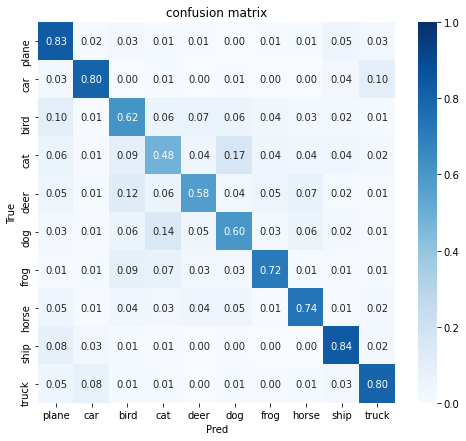

In [41]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_true_all, p_batch_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(8,7))
labels = classnames.values()

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=classnames.values(), yticklabels=classnames.values())

plt.ylabel("True")
plt.xlabel("Pred")
plt.title("confusion matrix")

# Conclusion

That's it for this week. Now you can try to improve the test accuracy by changing hyper parameters.